### Objetivo:

**Analizar los resultados provisorios de las Elecciones PASO Presidenciales en busca de posibles irregularidades en el proceso de conteo y carga de datos.**

Se buscó analizar de **manera explorativa** tanto los datos presentes en el telegrama como posibles errores en el ingreso de datos al sistema de recuento que generen discrepancias entre lo que dice el papel y lo que quedó registrado en el sistema.

### Introducción

 - La base de datos fue obtenida a través del Grupo OpenDataCórdoba. Los datos venian en un archivo SQLite.
 - De la base de datos extraje 3 tablas:
  - NomPartidos: Para identificar los Partidos
  - MesasCandidaturasPresidente: Para extraer la cantidad de votos a presidente de cada partido. No está desglozado por candidato, sino por Frente/Alianza.
  - NomAmbitos: Para identificar a través de texto las localidades


### Read and Merge Data

In [1]:
import pandas as pd
print "Pandas Version: ", pd.__version__
%pylab inline

Pandas Version:  0.16.2
Populating the interactive namespace from numpy and matplotlib


In [3]:
nom_partidos = pd.read_csv('./data/NomPartidos', encoding='iso-8859-1')
nom_partidos['parSiglas'] = nom_partidos.parSiglas.replace("ALIANZA FRENTE PARA LA VI", "FPV")
nom_partidos['parSiglas'] = nom_partidos.parSiglas.replace("ALIANZA UNIDOS POR UNA NU", "UNA")
nom_partidos['parSiglas'] = nom_partidos.parSiglas.replace("ALIANZA CAMBIEMOS        ", "CAMBIEMOS")

mesas_presidente = pd.read_csv('./data/MesasCandidaturaPresidente', encoding='iso-8859-1')
nom_ambitos = pd.read_csv('./data/NomAmbitos', encoding='iso-8859-1')

nom_partidos.replace({'á': 'a','é': 'e','í': 'i','ó': 'o','ú': 'u'}, inplace=True, regex=True)
nom_ambitos.replace({'á': 'a','é': 'e','í': 'i','ó': 'o','ú': 'u'}, inplace=True, regex=True)

m1 = pd.merge(nom_partidos, mesas_presidente, left_on='parCodigo', right_on='vot_parCodigo')
votos_presidente_complete = pd.merge(m1, nom_ambitos, left_on=['vot_proCodigoProvincia','vot_depCodigoDepartamento'], right_on=['depCodigoProvincia', 'depCodigoDepartamento'])
votos_presidente_complete = pd.DataFrame(votos_presidente_complete)

columns = ['vot_proCodigoProvincia','depNombre', 'vot_munCodigoMunicipio', 'vot_mesCodigoCircuito', 'vot_mesCodigoMesa','parSiglas', 'vot_parCodigo', 'votVotosPartido']
votos_presidente = votos_presidente_complete[columns]
votos_presidente.columns = ['codigo_provincia','nombre_departamento', 'codigo_municipio', 'codigo_circuito', 'codigo_mesa','alianza', 'codigo_partido', 'votos']

/home/patodb/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/home/patodb/anaconda/lib/python2.7/site-packages/pandas/core/internals.py:3878: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  res = op(a, b)


### Busqueda de mesas con posibles errores.

##### Top N Mesas con mayor cantidad de votos

El primer criterio es buscar y checkear las mesas donde más votos se obtuvieron por partido. Sospecho que en donde más votos se sacaron, más posibilidades de sumar votos inexistentes había. Una vez identificadas, contrasté una por una en la página web www.resultados.gob.ar. Llegué a analizar las primeras 35 mesas, puede que hallan más.

In [4]:
cantidad_mesas = 35
top = votos_presidente.loc[votos_presidente.votos.order(ascending=False).head(cantidad_mesas).index]

Resultados después de checkear a mano:
 - La mayoría de estas mesas presentan errores entre lo expresado en el Telegrama y lo Expresado en el sistema.
  - Hay errores de Data Entry, se confundían los 0 con 6. (Cabe recalcar que la escritura no era muy prolija aunque en la lógica general se entendía que ese número era imposible)
    - Ejemplo: 
  - Hay errores donde el Total de Votos no coincide con los Registrados en la planilla.
    - Ejemplo: Buenos Aires - Moron - 0669 - 364
  - Hay datos que no presetan incoherencia entre lo ingresado en el sitema y el telegrama enviado. No obstante, la cantidad de votos alta puede indicar que los datos pueden ser erroneos. Iguamente no tengo suficiente información para afirmar irregularidad alguna.
    - Ejemplo: 
 - En la Mayoria de las mesas donde la alianza UNA sacó muchos votos, la cantidad de votos asignada es en realidad (según los números del telegrama) la cantidad total de votos de la mesa. En Muchos casos, el telegrama no presenta nada escrito en los casilleros y sin embargo, en el sistema, se registró el total de votos de la Mesa, a dicho candidato (Ver Ejemplo 2, Ejemplo 3 y Ejemplo 4).
  - Ejemplo: Buenos Aires - Moreno- 663D - 00671
  - Ejemplo 2: Buenos Aires - Zarate - 1013 - 26
  - Ejemplo 3: Buenos Aires - La Plata - 0497 - 583
  - Ejemplo 4: Buenos Aires - La Matanza - 631D - 1251

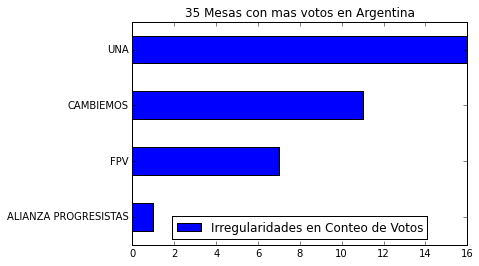

In [40]:
top.alianza.value_counts().order().plot(kind='barh', title="35 Mesas con mas votos en Argentina")
plt.legend(loc="lower center").get_texts()[0].set_text('Irregularidades en Conteo de Votos')

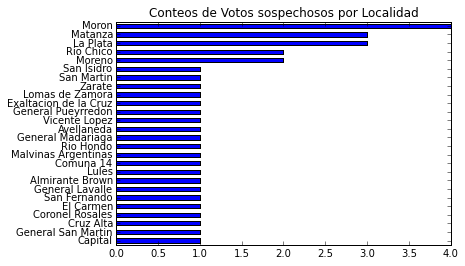

In [42]:
top.nombre_departamento.value_counts().order().plot(kind='barh', title="Conteos de Votos sospechosos por Localidad")

In [43]:
top.drop(['codigo_partido', 'codigo_municipio'], axis=1).reset_index(drop=True)

,codigo_provincia,nombre_departamento,codigo_circuito,codigo_mesa,alianza,votos
0,2,General Madariaga,0340,18,ALIANZA PROGRESISTAS,805
1,2,Matanza,0635E,2720,FPV,793
2,2,San Isidro,0892,398,CAMBIEMOS,757
3,2,General Pueyrredon,0364,112,CAMBIEMOS,682
4,2,Moron,0673,662,CAMBIEMOS,678
5,2,General San Martin,0388,913,UNA,660
6,2,La Plata,0496,391,UNA,657
7,2,Almirante Brown,0021A,888,CAMBIEMOS,645
8,2,Avellaneda,0030,184,CAMBIEMOS,644
9,10,El Carmen,0031,821,CAMBIEMOS,386


### Desviaciones de la Media

In [44]:
from scipy.stats.mstats import normaltest

In [45]:
print 'Normal Test'
print 'UNA: teststat = %6.3f and pvalue = %6.4f' % normaltest(votos_presidente[(votos_presidente.alianza == "UNA")].votos)
print 'FPV: teststat = %6.3f and pvalue = %6.4f' % normaltest(votos_presidente[votos_presidente.alianza == "FPV"].votos)
print 'CAMBIEMOS: teststat = %6.3f and pvalue = %6.4f' % normaltest(votos_presidente[votos_presidente.alianza == "CAMBIEMOS"].votos)

Normal Test
UNA: teststat = 32383.502 and pvalue = 0.0000
FPV: teststat = 2266.021 and pvalue = 0.0000
CAMBIEMOS: teststat = 14191.301 and pvalue = 0.0000


El siguiente análisis se basa en:
 - Calcular Por Provincia, Municipio, y Circuito, el promedio y desviación estándar de los votos de cada Alianza
 - Identificar luego, aquellos circuitos con mesas donde la cantidad de votos para el partido difiere en mas de X Desviaciones Estandar de la media. (Estadísticamente poco probable)
 - X será definido en base a obtene un subset lo suficientemente chico como para poder revisarlo a mano.

In [46]:
# Los partidos chicos dan muchos falsos positivos así que los filtramos por ahora
votos_principales_alianzas = votos_presidente[votos_presidente.alianza.isin(["CAMBIEMOS", "FPV", "UNA"])]

In [47]:
# Estadística Básica de cada Alianza por Circuito.
circuitos = votos_principales_alianzas.groupby(['codigo_provincia','codigo_municipio','codigo_circuito', 'alianza'], as_index=False).votos.describe()
circuitos = circuitos.dropna()

In [48]:
circuitos_dudosos = circuitos[(circuitos['max'] - circuitos['mean']) > (circuitos['std'] * 7)]
circuitos_dudosos = circuitos_dudosos[circuitos_dudosos['max'] < 305] # Mesas ya analizadas en el Top N
print "Cantidad de Circuitos con mesas dudosas: ", circuitos_dudosos.shape[0]
circuitos_dudosos.reset_index(inplace=True)

Cantidad de Circuitos con mesas dudosas:  28


In [49]:
mesas_dudosas = pd.merge(votos_presidente, circuitos_dudosos, left_on=['codigo_provincia','codigo_municipio','codigo_circuito','alianza','votos'], right_on=['codigo_provincia','codigo_municipio','codigo_circuito','alianza','max'])
mesas_dudosas = mesas_dudosas[['codigo_provincia','nombre_departamento','codigo_municipio','codigo_circuito','codigo_mesa','alianza','votos']].sort('votos',ascending=False).reset_index(drop=True)
mesas_dudosas

,codigo_provincia,nombre_departamento,codigo_municipio,codigo_circuito,codigo_mesa,alianza,votos
0,2,San Isidro,106,0892,316,UNA,303
1,2,Vicente Lopez,122,1000,516,UNA,297
2,2,Quilmes,92,0788,741,UNA,291
3,2,Hurlingham,134,0668,57,UNA,286
4,2,Ituzaingo,133,0667,338,FPV,285
5,2,Lomas de Zamora,70,0583,360,UNA,279
6,2,Ezeiza,132,0289,122,UNA,277
7,2,Matanza,61,0635A,2038,UNA,274
8,2,General Pueyrredon,50,0366A,1031,UNA,264
9,2,San Vicente,109,0924,25,UNA,259


Conclusiones después de revisar a mano cada fila:
 - 0: Datos no encontrados
 - 1, 2, 3: UNA tiene contabilizados los votos totales de la mesa y no los correspondientes
 - 4: FPV tiene más votos en el Telegrama que la cantidad de votantes en esa Mesa.
 - 5 - 10: UNA tiene contabilizados los votos totales de la mesa y no los correspondientes
 - 11: Cambiemos tiene 251 Votos, hay más votos que votantes.
 - 12, 13: UNA tiene contabilizados los votos totales de la mesa y no los correspondientes
 - 14: La cantidad de Votantes supera al Total de la Mesa
 - 15: Puede presentar Falso Positivo al ser comparado con el Telegrama
 - 16 Lectura Ilegible, Cantidad de Votos Mayor al total de la Mesa
 - 17: Puede presentar Falso Positivo al ser comparado con el Telegrama
 - 18: Puede presentar Falso Positivo al ser comparado con el Telegrama
 - 19: Datos Ilegibles en Alianza Cambiemos, dificil distinguir si 40 o 90 en los casilleros
 - 20: 

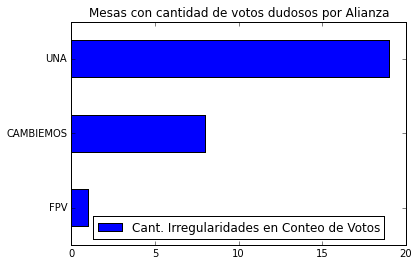

In [51]:
mesas_dudosas.alianza.value_counts().order(ascending=True).plot(kind='barh', title=u'Mesas con cantidad de votos dudosos por Alianza')
plt.legend(loc="lower center").get_texts()[0].set_text('Cant. Irregularidades en Conteo de Votos')

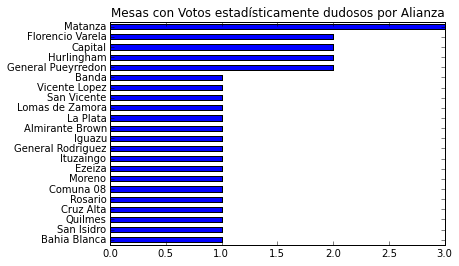

In [52]:
mesas_dudosas.nombre_departamento.value_counts().order(ascending=True).plot(kind='barh', title=u'Mesas con Votos estadísticamente dudosos por Alianza')

##### Cantidad de Mesas con 0 votos registrados

In [69]:
print "Cant Mesas donde el FPV saco 0 votos: ", sum(votos_presidente[votos_presidente.alianza == "FPV"].votos == 0)
print "Cant Mesas donde Cambiemos saco 0 votos: ", sum(votos_presidente[votos_presidente.alianza == "CAMBIEMOS"].votos == 0)
print "Cant Mesas donde UNA saco 0 votos: ", sum(votos_presidente[votos_presidente.alianza == "UNA"].votos == 0)

Cant Mesas donde el FPV saco 0 votos:  3697
Cant Mesas donde Cambiemos saco 0 votos:  3750
Cant Mesas donde UNA saco 0 votos:  4106


##### Listado de mesas donde hay 0 votos para esos partidos

In [70]:
mesas_sin_votos_fpv = votos_presidente[(votos_presidente.alianza == "FPV") & (votos_presidente.votos == 0)]
mesas_sin_votos_cambiemos = votos_presidente[(votos_presidente.alianza == "CAMBIEMOS") & (votos_presidente.votos == 0)]
mesas_sin_votos_una = votos_presidente[(votos_presidente.alianza == "UNA") & (votos_presidente.votos == 0)]